# Automate extraction of handwritten text from an image


Project done by Ajuma Mohammed, ICT Academy , TCS iON RIO125

In [1]:
#Loading necessary libraries

from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
# %matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop
from google.colab import drive

In [2]:
#Mounting Google drive to access dataset

drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Data Pre-processing

### dataset used: IAM dataset, line images

In [ ]:
#These are the forms in the dataset for quick access from manipulation of the file names on each column. Let's create a dictionary with form and writer

d = {}

from subprocess import check_output
with open('/content/gdrive/MyDrive/TCS_ion Internship/DataIAM/forms_for_parsing.txt') as f:
  for line in f:
    if line.startswith('#'):
      continue
    key = line.split(' ')[0]
    writer = line.split(' ')[1]
    print(key," :: ", writer)
    d[key] = writer
print(len(d.keys()))


In [4]:
#All file-names list and target-writer names list are created

tmp = []
target_list = []
tempDict = {}
tempDict = d.copy()
#print(tempDict)

path_to_files = os.path.join('//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset', '*')
for filename in sorted(glob.glob(path_to_files)):
  #print(filename)
  tmp.append(filename)
  image_name = filename.split('/')[-1]
  file, ext = os.path.splitext(image_name)
  parts = file.split('-')
  form = parts[0] + '-' + parts[1]
  tempDict = d.copy()
  val = tempDict.get(form)
  #for key in d:
  if val:
      target_list.append(str(val))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

#visualize the image data
#for filename in img_files[:3]:
 # img = mpimg.imread(filename)
 # plt.figure(figsize=(10,10))
 # plt.imshow(img, cmap ='gray')




(4899,)
(4899,)


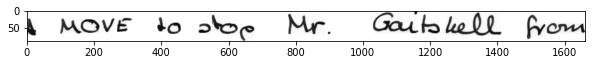

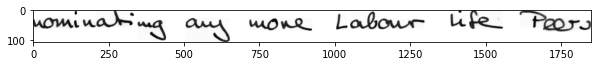

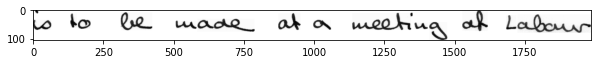

In [5]:
# visualize the image data

for filename in img_files[:3]: 
  img=mpimg.imread(filename) 
  plt.figure(figsize=(10,10)) 
  plt.imshow(img, cmap ='gray')

### Encoding Labels

In [6]:
# normalisation is done using label ENCODER. No, categorical data

encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:10], img_targets[:10], encoded_Y[:10])

['//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-000u-s00-00.png'
 '//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-000u-s00-01.png'
 '//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-000u-s00-02.png'
 '//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-000u-s00-03.png'
 '//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-000u-s01-00.png'
 '//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-000u-s01-01.png'
 '//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-000u-s01-02.png'
 '//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-000u-s01-03.png'
 '//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-003u-s00-00.png'
 '//content/gdrive/MyDrive/TCS_ion Internship/DataIAM/dataset/a01-003u-s00-01.png'] ['000' '000' '000' '000' '000' '000' '000' '000' '000' '000'] [0 0 0 0 0 0 0 0 0 0]


# Generating Train and Test and Validation data

In [7]:
# Splitting of data into training and validation sets for cross validation with 4;1;1 ratio

train_files, rem_files, train_targets, rem_targets = train_test_split(
img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True) 

val_files, test_files, val_targets, test_targets = train_test_split(
rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True) 

print(train_files.shape,val_files.shape, test_files.shape)
print(train_targets.shape, val_targets.shape, test_targets.shape)


(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [8]:
# Generator function for generating random crops from each sentence randomly cropping 

BATCH_SIZE = 16
NUM_CLASSES = 50
CROP_SIZE = 113

def generate_data(samples, target_files, batch_size=BATCH_SIZE, factor = 0.1 ): 
  num_samples = len(samples)
  from sklearn.utils import shuffle
  while 1: # Loop forever so the generator never terminates
    for offset in range(0, num_samples, batch_size): 
      batch_samples = samples[offset:offset+batch_size] 
      batch_targets = target_files[offset:offset+batch_size]

      images = []
      targets = []

      for i in range(len(batch_samples)):
        batch_sample = batch_samples[i]
        batch_target = batch_targets[i]
        im = Image.open(batch_sample)
        cur_width = im.size[0]
        cur_height = im.size[1]

        # print(cur_width, cur_height)
        height_fac = CROP_SIZE / cur_height

        new_width = int(cur_width * height_fac)
        size = new_width, CROP_SIZE
  
        imresize = im.resize((size), Image.ANTIALIAS) # Resize so height = 113 while keeping aspect ratio
        now_width = imresize.size[0]
        now_height = imresize.size[1]

        # Generate crops of size 113x113 from this resized image and keep random 10% of crops

        avail_x_points = list(range(0, now_width - CROP_SIZE ))# total x start points are from 0 to width -113
  
        # Pick random x%
        pick_num = int(len(avail_x_points)*factor) 
  
        # Now pick
        random_startx = sample(avail_x_points,  pick_num)

        for start in random_startx:
            imcrop = imresize.crop((start, 0, start+CROP_SIZE, CROP_SIZE)) 
            images.append(np.asarray(imcrop)) 
            targets.append(batch_target)
    
    # trim image to only see section with road
    X_train = np.array(images)
    y_train = np.array(targets)
          
   
    #reshape X_train for feeding in later
    X_train = X_train.reshape(X_train.shape[0], CROP_SIZE, CROP_SIZE, 1) 
    
    #convert to float and normalize
    X_train = X_train.astype('float32')
    X_train /= 255

    #One hot encode y
    y_train = to_categorical(y_train, NUM_CLASSES) 
    yield shuffle(X_train, y_train)






In [18]:
# For training and testing, generator function is called with the intent of making train and test generator data

train_generator = generate_data(train_files, train_targets, batch_size=BATCH_SIZE, factor = 0.3)
validation_generator = generate_data(val_files, val_targets, batch_size=BATCH_SIZE, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=BATCH_SIZE, factor = 0.1)


# Building Model using Keras and Tensorflow

In [19]:
# A Keras Model is built. Summary of the model is printed below. 
import tensorflow as tf

def resize_image(image):
  return tf.image.resize(image,[56,56])
      
# Function to resize image to 64x64
row, col, ch = CROP_SIZE, CROP_SIZE, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resize data within the neural network
model.add(Lambda(resize_image)) #resize images to allow for easy computation 
#model.add(Lambda(lambda x: resize_image))

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))
 
model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same' , name='conv2')) #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters=128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3')) #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, name='dense1')) #1024 
# model.add(BatchNormalization()) 
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(64, name='dense2')) #1024 
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES,name='output'))
model.add(Activation('softmax')) #softmax since output is within 50 classes 
print("Worked till here")
 
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())

Worked till here
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPaddi  (None, 115, 115, 1)      0         
 ng2D)                                                           
                                                                 
 lambda_1 (Lambda)           (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation_6 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                     

# Training Model and saving it to Google Drive

In [ ]:
from keras.callbacks import ModelCheckpoint

# Training the Model 
nb_epoch = 4

steps_per_epoch = 100
_nb_val_steps = 62


# #save every model using Keras checkpoint
filepath="/content/gdrive/MyDrive/TCS_ion Internship/check-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False) 
callbacks_list = [checkpoint]

# #Model fit generator
#history_object = model.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, validation_data=validation_generator, validation_steps=nb_val_steps, validation_freq=nb_epoch, verbose=1, callbacks = callbacks_list)

history_object = model.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, validation_data=validation_generator,
                                               validation_steps=nb_val_steps, validation_freq=nb_epoch, verbose=1, callbacks = callbacks_list)

#model.fit(train_generator,
    #steps_per_epoch=2048 // 128, epochs=10,
   # validation_data=validation_generator, validation_steps=832//16)

<ipython-input-46-d8656c82563f>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_object = model.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, validation_data=validation_generator,


100/100 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9986 
Epoch 1: saving model to /content/gdrive/MyDrive/TCS_ion Internship/check-01.hdf5
100/100 [==============================] - 5707s 58s/step - loss: 0.0076 - accuracy: 0.9986


In [23]:
#Saving the model and weights into GDrive

from keras.models import model_from_json   
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/MyDrive/TCS_ion Internship/HTR Model/HTR_Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/MyDrive/TCS_ion Internship/HTR Model/HTR_model_weights.hdf5")
print("Saved model to GDrive")

Saved model to GDrive


In [24]:
#Loading json and weights to recover model
import tensorflow as tf
json_file = open("/content/gdrive/MyDrive/TCS_ion Internship/HTR Model/HTR_Model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
l_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
l_model.load_weights("/content/gdrive/MyDrive/TCS_ion Internship/HTR Model/HTR_model_weights.hdf5")
print("Loaded model from Gdrive")

Loaded model from Gdrive


In [25]:
model.save("/content/gdrive/MyDrive/TCS_ion Internship/HTR Model/HTR_model.hdf5")
print("Saved Keras Model")

Saved Keras Model


In [26]:
#from keras.models import load_model
# load model
from tensorflow import keras
loaded_model = keras.models.load_model("/content/gdrive/MyDrive/TCS_ion Internship/HTR Model/HTR_model.hdf5", custom_objects=None, compile=True, options=None)
print("Loaded the Keras Model")

Loaded the Keras Model


# Model Prediction

In [ ]:
images = []
for filename in test_files[:50]:
  im = Image.open(filename)

  cur_width = im.size[0]
  cur_height = im.size[1]

  print("Before crop:", cur_width, cur_height)
  height_fac = 113 / cur_height

  new_width = int(cur_width * height_fac)
  size = new_width, 113

  imresize = im.resize((size), Image.ANTIALIAS) #resize so height = 113 while keeping aspect ratio
  now_width = imresize.size[0]
  now_height = imresize.size[1]
  print("After Crop:", now_width, now_height)

  #Generate crops of size 113*113 from this resized image and keep random 10% of crops
  avail_x_points = list(range(0, now_width - 113)) #total * start points are from 0 to width -113

  # pick random x%
  factor = 0.1
  pick_num = int(len(avail_x_points)*factor)
  print("Pick Number is : :", pick_num)

  random_startx = sample(avail_x_points, pick_num)

  for start in random_startx:
    imcrop = imresize.crop((start, 0, start+113, 113))
    images.append(np.asarray(imcrop))

  X_test = np.array(images)

  X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
 
  #convert to float and normalize
  X_test = X_test.astype('float32')
  X_test /= 255
  shuffle(X_test)

print(X_test.shape)


199/199 [==============================] - 1s 3ms/step
(6351, 50)
6351


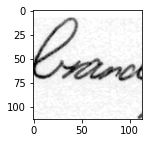

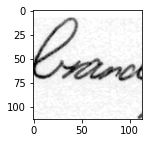

In [29]:
from functools import total_ordering
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
  predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

#Mapping Test image with trained image
writer_number = 18
total_images = 10
counter =0

for i in range(len(predicted_writer)//10):
  if predicted_writer[i] == writer_number:
    image = X_test[i].squeeze()
    plt.figure(figsize = (2,2))
    plt.imshow(image, cmap = 'gray')

image1 = X_test[0].squeeze()
image2 = X_test[1].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image1, cmap = 'gray')

plt.figure(figsize=(2,2))
plt.imshow(image2, cmap = 'gray')

In [35]:

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

(6351, 50)
6351


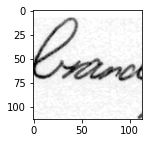

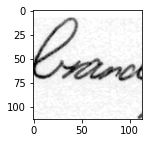

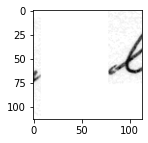

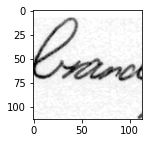

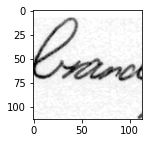

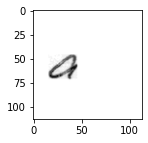

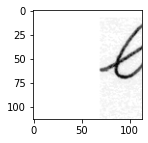

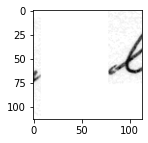

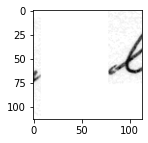

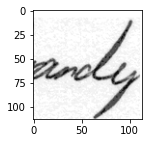

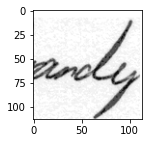

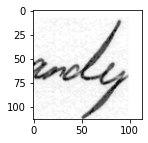

In [41]:
writer_number = 8
total_images =10
counter = 0
for i in range(len(predicted_writer)//500):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')

Submitted By : Ajuma Mohammed, KKEM ML/AI Aug2022 Batch